# SWB Regression Pipeline - Alpha Power 
Created: 07/30/24 \
Updated: 09/25/2024 \
*updated with 1sec regression epochs*

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
# from sklearn.linear_model import RANSACRegressor
# from sklearn.metrics import r2_score, mean_squared_error



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/'
anat_dir   = f'{base_dir}recon_labels/'
neural_dir = f'{base_dir}data/'
save_dir   = f'{base_dir}results/regression_data/'
fig_dir    = f'{base_dir}figs/regression_figs/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'


date = datetime.date.today().strftime('%m%d%Y')
print(date)



09252024


In [4]:
import sys
sys.path.append(f'{base_dir}LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS009,16
3,MS011,13
4,MS015,26
5,MS016,10
6,MS017,26
7,MS019,12
8,MS022,10
9,MS024,16


In [12]:
# #### set theme for all plots
# # %matplotlib inline
# # from matplotlib import rc
# # rc('text', usetex=False)

# sns.set_theme(style='ticks') 
# sns.set_context("poster")



In [8]:
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# import matplotlib as mpl
# from matplotlib import cm


# # saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# # 671351
# saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
# saez_hex_cmap  = ListedColormap(saez_colors)
# saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
# saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
# #plot_palette = saez_linear_cmap.resampled(lutsize=30)
# expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


# Load beta power data 

In [7]:
epoch_len = '1sec'

In [8]:
band = 'alpha'
alpha_df = pd.read_csv(f'{save_dir}{band}_master_df_{epoch_len}.csv')
alpha_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [9]:
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [10]:
roi_reref_labels_master_df.roi.value_counts()

roi
dmpfc            225
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
temporal         105
vlpfc             82
ains              71
pins              60
thalamus          58
temporal pole     31
mcc               28
phg               25
motor             25
parietal          24
vmpfc             23
caudate            8
pcc                1
Name: count, dtype: int64

In [11]:
# #### filter df by rois with electrode counts >= 50 *** updated to >15
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[roi_reref_labels_master_df.roi.value_counts(
# ).values>=20].tolist()

keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','amy','hpc']     

keep_rois


['dlpfc', 'vlpfc', 'dmpfc', 'ofc', 'ains', 'pins', 'acc', 'amy', 'hpc']

In [12]:
# ####### NEW DATA FRAME 
alpha_reg_df = alpha_df.copy()
alpha_reg_df = alpha_reg_df[alpha_reg_df.roi.isin(keep_rois)]

# Test Single Electrode Regressions 

In [13]:
elec_col    = 'unique_reref_ch'
main_var    = 'cpe'
reg_formula = 'band_pow~GambleChoice+TotalProfit+cpe'
# n_permutations = 1000
# results_dict, main_var_sig = run_individual_elec_regression(alpha_reg_df,reg_formula,
#                                                             elec_col, main_var,n_permutations)



In [ ]:
# save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
# save_vars


In [ ]:
# results = single_elec_permutation_results(results_dict,alpha_reg_df,save_vars)
# results



In [ ]:
# # # create a binary pickle file 
# pickle.dump(results,
#             open(f'{save_dir}single_elec_regression_{band}_{reg_formula}_{epoch_len}_{date}.pkl',"wb"))




In [15]:

results = pickle.load(open(f'{save_dir}single_elec_regression_alpha_band_pow~GambleChoice+TotalProfit+cpe_1sec_09252024.pkl',"rb"))



In [16]:
# sig_data = results[results.unique_elec_id.isin(main_var_sig)]
# sig_data

sig_data = results[results['P_Value_cpe']<0.05]
sig_data




,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_cpe,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_cpe,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_cpe,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_cpe
14,MS002_laims3-laims4,MS002,ains,14,0.076616,-0.030764,0.037216,0.149514,0.054018,0.001058,...,0.063146,0.060123,0.494057,-0.482722,0.613404,2.433113,0.621266,0.629293,0.539609,0.014970
26,MS002_lloif1-lloif2,MS002,ofc,14,-0.052135,0.017259,0.068640,0.112834,-0.041371,0.001445,...,0.048397,0.046811,-0.290848,0.296473,1.541539,2.372197,0.771168,0.766869,0.123186,0.017683
30,MS002_lloif7-lloif8,MS002,vlpfc,14,0.180922,-0.260954,-0.067672,0.134470,0.000704,-0.002503,...,0.062342,0.060117,3.936783,-3.917379,-1.090141,2.197815,0.000083,0.000090,0.275651,0.027962
36,MS002_lmoif11-lmoif12,MS002,vlpfc,14,-0.105014,-0.009341,-0.035443,0.084576,-0.113275,0.001786,...,0.036704,0.034966,0.327661,-0.306135,-0.984685,2.442947,0.743168,0.759502,0.324779,0.014568
57,MS002_ragit3-ragit4,MS002,amy,14,-0.034587,-0.020873,-0.072435,0.083389,-0.050398,0.000921,...,0.041484,0.040982,0.513835,-0.491310,-1.720356,2.111701,0.607367,0.623207,0.085368,0.034712
64,MS002_raims12-raims13,MS002,dlpfc,14,0.065878,-0.030108,-0.020345,0.164988,0.045385,-0.001802,...,0.064861,0.061891,0.443803,-0.425134,-0.341069,2.676051,0.657185,0.670739,0.733052,0.007450
86,MS003_laimm3-laimm4,MS003,ains,8,-0.233018,0.093657,0.025972,0.084471,-0.200439,-0.000176,...,0.039774,0.036667,-2.310051,2.294491,0.661688,2.300045,0.020885,0.021762,0.508171,0.021446
116,MS003_raimm5-raimm6,MS003,vlpfc,8,-0.163699,0.038277,-0.037079,0.125728,-0.150423,0.002340,...,0.042160,0.040229,-0.879648,0.820726,-0.896251,3.155394,0.379050,0.411803,0.370119,0.001603
154,MS009_lhpit1-lhpit2,MS009,hpc,16,-0.051316,0.077948,0.126242,-0.166048,-0.006543,0.000518,...,0.074058,0.077971,-1.078149,1.033717,1.723102,-2.115676,0.280967,0.301269,0.084870,0.034372
211,MS015_lhplt2-lhplt3,MS015,hpc,26,0.032361,-0.087019,0.001222,0.148587,0.012419,-0.001994,...,0.061571,0.064656,1.110050,-1.070840,0.035513,2.238846,0.266977,0.284241,0.971671,0.025166


In [17]:
sig_data.roi.value_counts()



roi
ofc      11
hpc       9
vlpfc     9
dmpfc     7
dlpfc     7
amy       6
ains      4
acc       2
pins      1
Name: count, dtype: int64

In [18]:
sig_data.roi.unique()



array(['ains', 'ofc', 'vlpfc', 'amy', 'dlpfc', 'hpc', 'dmpfc', 'pins',
       'acc'], dtype=object)

In [19]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()

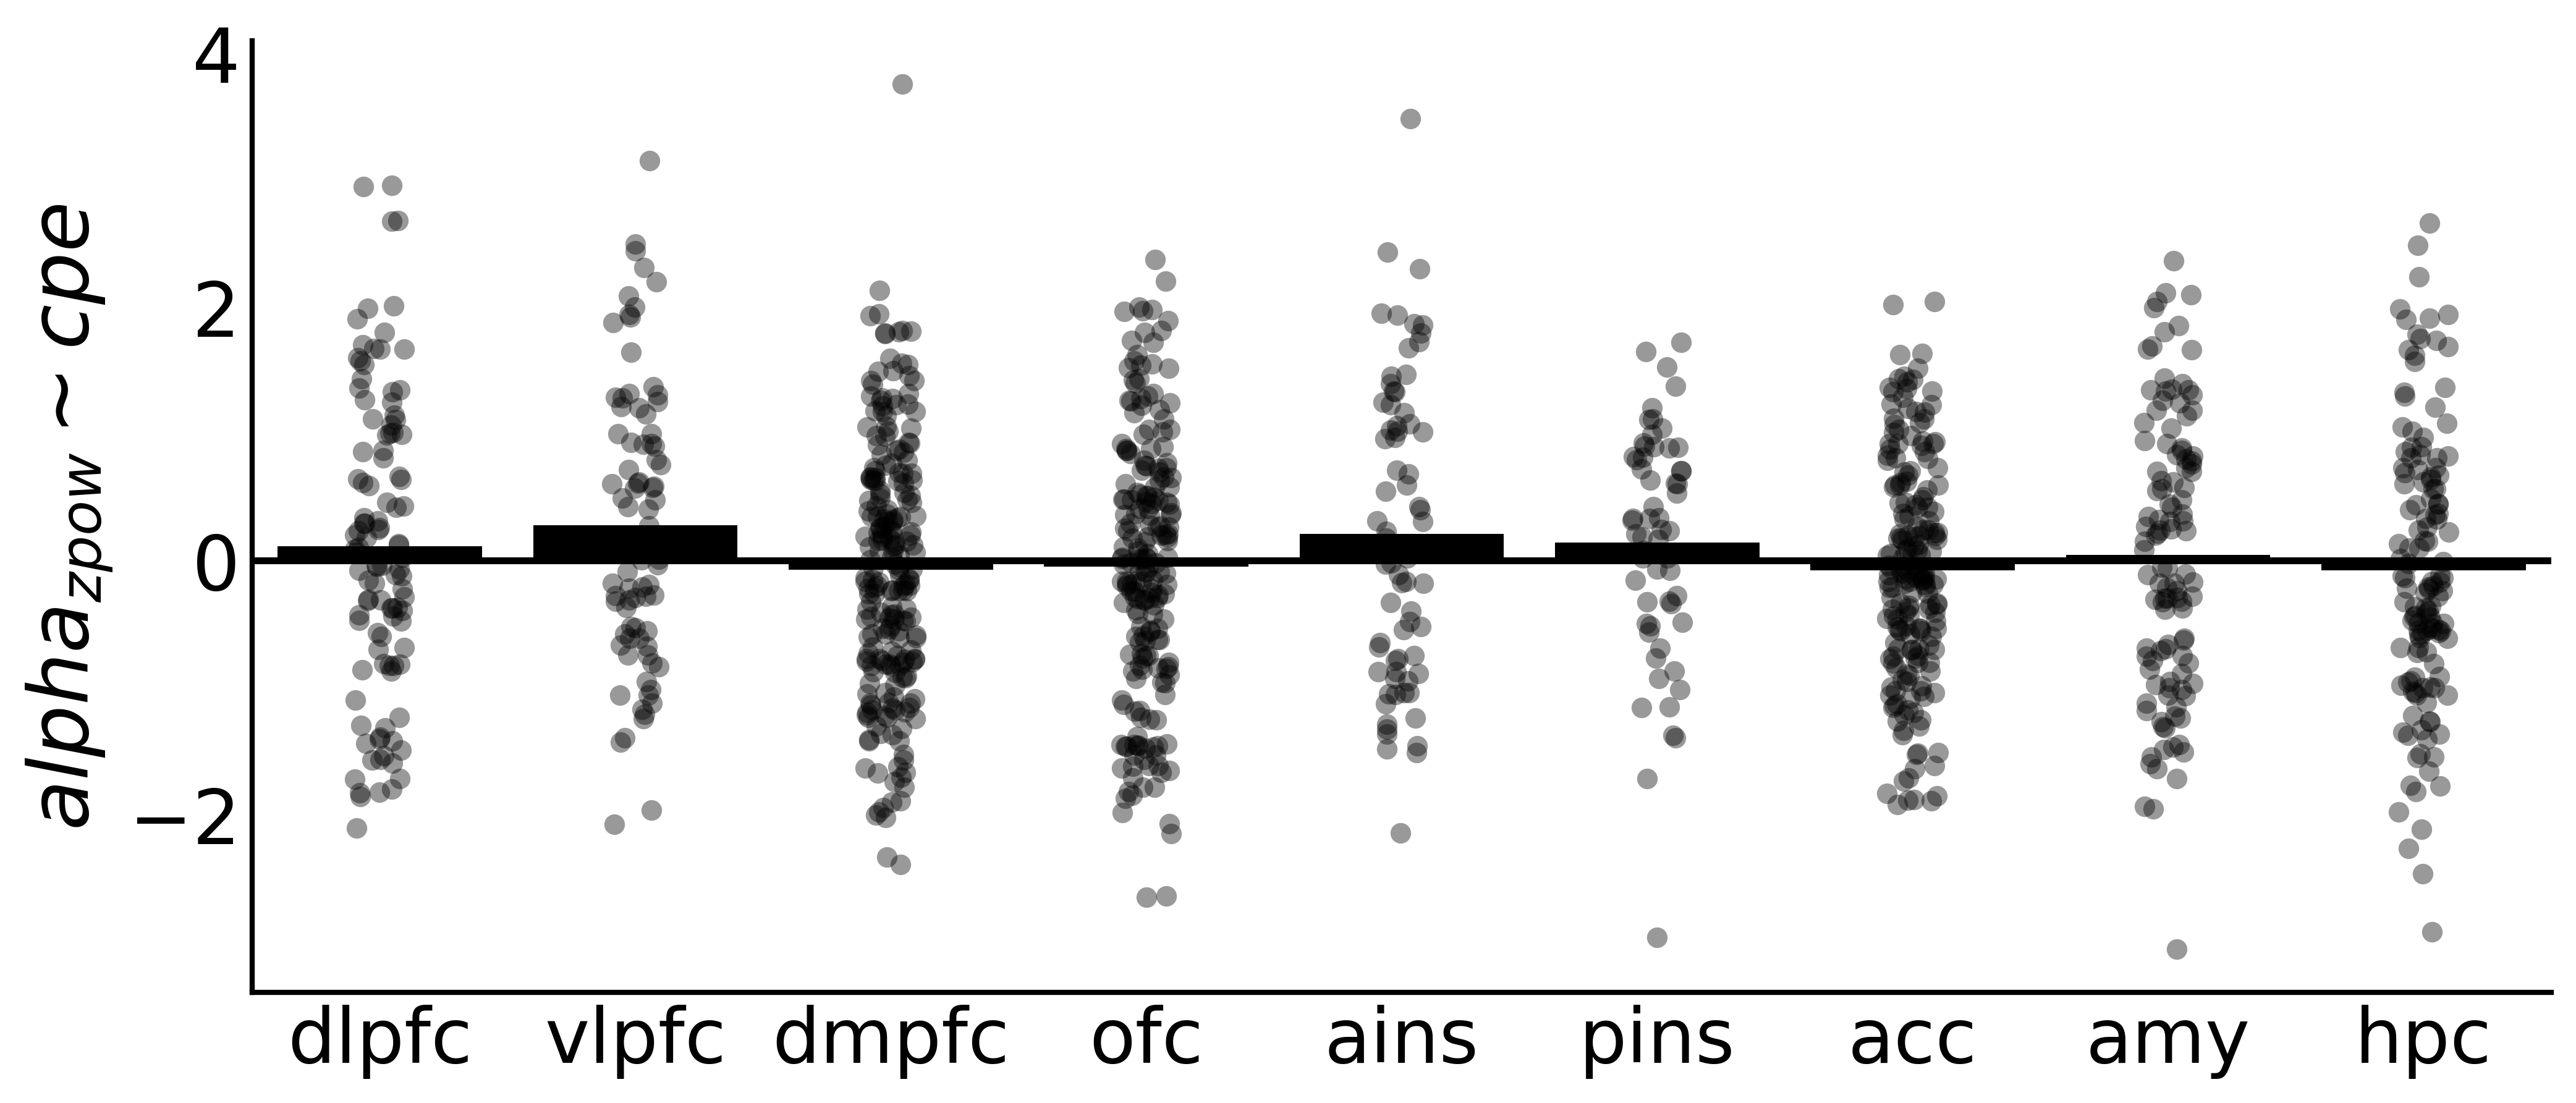

In [20]:
# plot_roi_model_results(results,'roi','Z_Score_decisionCPE',bar_order=bar_order,figsize=(12,4),color='k')
# green '#135546'

ylabel = fr'${band}_{{zpow}} \sim cpe$'
fig_id = f'{band}_single_elec_roi_barplot_{epoch_len}.pdf'

plot_roi_model_results(results,'roi','Z_Score_cpe',bar_order=bar_order,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_dir,fig_id=fig_id,dpi=400)





In [21]:
results.to_csv(f'{save_dir}{band}_single_elec_perm_results_{epoch_len}.csv')

In [22]:
results.groupby('roi').agg('mean',numeric_only=True)['Z_Score_cpe'][bar_order]



roi
dlpfc    0.115033
vlpfc    0.278984
dmpfc   -0.073562
ofc     -0.045427
ains     0.211464
pins     0.141396
acc     -0.077622
amy      0.044570
hpc     -0.077809
Name: Z_Score_cpe, dtype: float64

In [26]:
single_elec_res = results.copy()[results.roi.isin(bar_order)]
single_elec_res



,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_cpe,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_cpe,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_cpe,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_cpe
0,MS002_lacas1-lacas2,MS002,acc,14,0.149789,-0.191950,0.076299,-0.043559,0.017211,-0.000135,...,0.066071,0.063362,2.669058,-2.677688,1.205251,-0.668118,0.007606,0.007413,0.228107,0.504058
1,MS002_lacas2-lacas3,MS002,acc,14,-0.007130,-0.012217,0.077693,-0.019914,-0.017426,0.003224,...,0.056853,0.053469,0.251433,-0.261665,1.380890,-0.406011,0.801479,0.793579,0.167313,0.684735
2,MS002_lacas3-lacas4,MS002,acc,14,0.057898,-0.059872,0.090895,-0.000786,0.017723,-0.001455,...,0.052810,0.053075,1.014309,-1.023371,1.728886,0.047545,0.310436,0.306132,0.083829,0.962079
3,MS002_lacas4-lacas5,MS002,acc,14,-0.047707,0.035402,0.055219,0.041890,-0.022514,-0.000860,...,0.050808,0.050122,-0.661164,0.660218,1.057872,0.806570,0.508507,0.509114,0.290114,0.419914
4,MS002_lacas5-lacas6,MS002,acc,14,0.095494,-0.055369,0.013616,0.066600,0.058679,-0.002680,...,0.060669,0.062932,0.806304,-0.800703,0.225803,1.074066,0.420068,0.423304,0.821355,0.282793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,DA039_rpins1-rpins2,DA039,pins,22,0.066132,0.018488,-0.047220,0.100428,0.075398,0.000764,...,0.070508,0.070757,-0.315309,0.240665,-0.686194,1.375141,0.752527,0.809815,0.492591,0.169088
1184,DA039_rpins2-rpins3,DA039,pins,22,0.035265,0.107220,-0.173460,0.065078,0.082859,-0.001733,...,0.069508,0.071953,-1.684793,1.541227,-2.512039,0.896303,0.092029,0.123261,0.012004,0.370091
1185,DA039_rpins3-rpins4,DA039,pins,22,-0.010378,-0.016246,-0.078740,0.089047,-0.012959,-0.002921,...,0.078798,0.074977,0.082375,-0.169455,-1.027051,1.202572,0.934349,0.865439,0.304397,0.229142
1186,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.034737,-0.008518,-0.107330,0.030022,-0.034881,-0.001986,...,0.048175,0.047074,0.007244,-0.131323,-2.258340,0.622291,0.994220,0.895520,0.023924,0.533751


In [27]:

single_rho_data = []
single_sig_rho = []

# BDI CORRELATIONS
for roi in single_elec_res.roi.unique().tolist():
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.Z_Score_cpe)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
#     fe_results['rho'][fe_results.roi==roi]   = rho
#     fe_results['rho_p'][fe_results.roi==roi] = rho_p
    
    single_rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':np.round(rho_p,4)},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        single_sig_rho.append((roi,rho,rho_p))
#     print(f'{roi} pearsonr',rho,rho_p)

single_rho_data = pd.concat(single_rho_data).reset_index(drop=True)



In [28]:
agg_single_results = single_elec_res.groupby('roi').agg('mean',numeric_only=True)[['Z_Score_cpe']].copy()

agg_single_results


,Z_Score_cpe
roi,
acc,-0.077622
ains,0.211464
amy,0.044570
dlpfc,0.115033
dmpfc,-0.073562
hpc,-0.077809
ofc,-0.045427
pins,0.141396
vlpfc,0.278984


In [29]:
single_rho_data = single_rho_data.set_index('roi')
single_rho_data['Z_Score_cpe'] = agg_single_results.Z_Score_cpe
single_rho_data[['Z_Score_cpe','rho','rho_p']]



,Z_Score_cpe,rho,rho_p
roi,,,
acc,-0.077622,-0.038590,0.5942
dmpfc,-0.073562,-0.159723,0.0165
amy,0.044570,0.073194,0.4410
ains,0.211464,-0.073300,0.5435
vlpfc,0.278984,-0.313389,0.0041
hpc,-0.077809,-0.258684,0.0025
ofc,-0.045427,-0.192951,0.0059
pins,0.141396,-0.071135,0.5891
dlpfc,0.115033,0.026358,0.7875


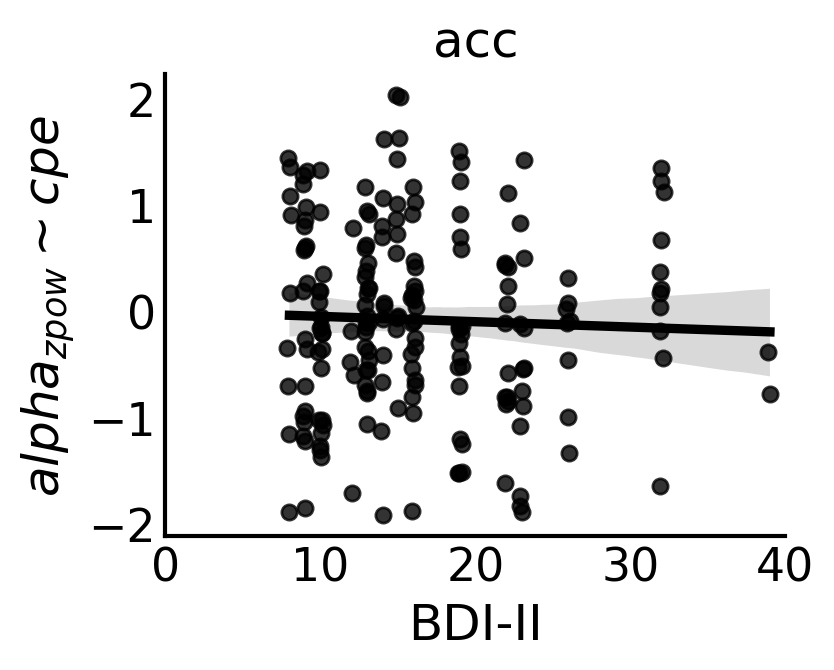

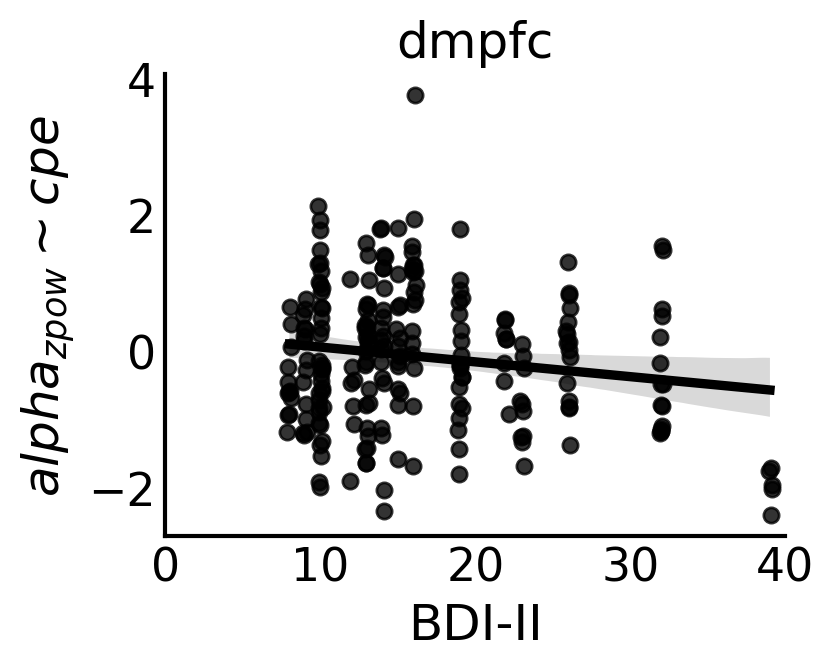

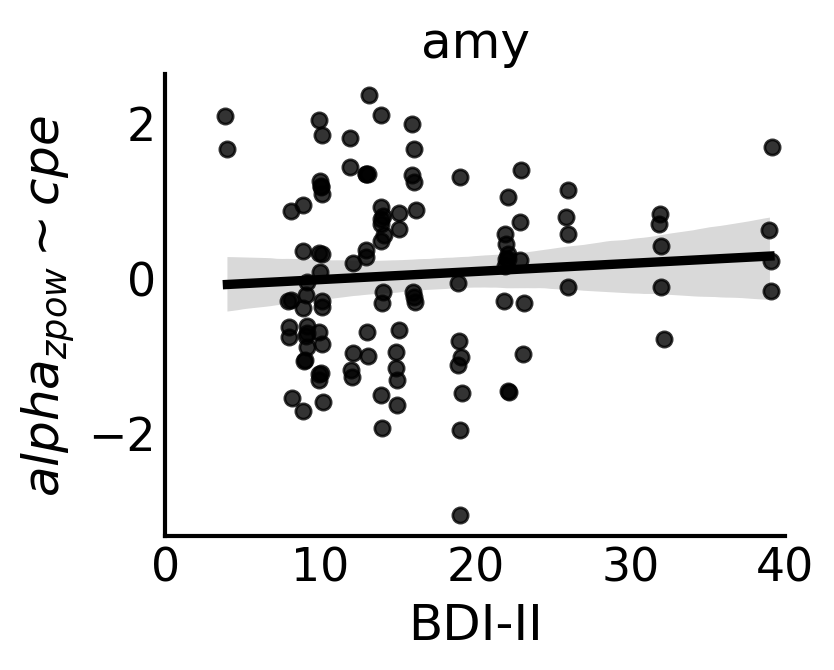

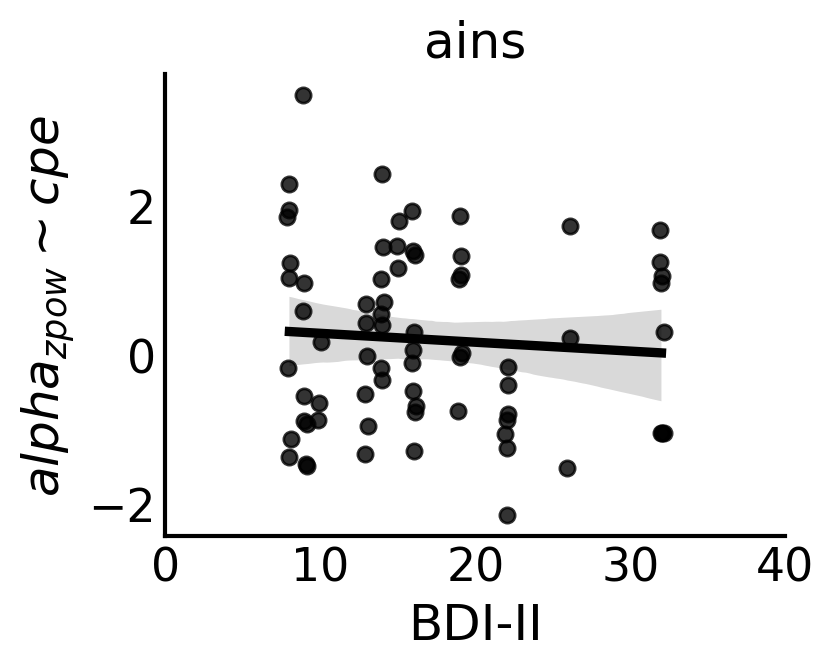

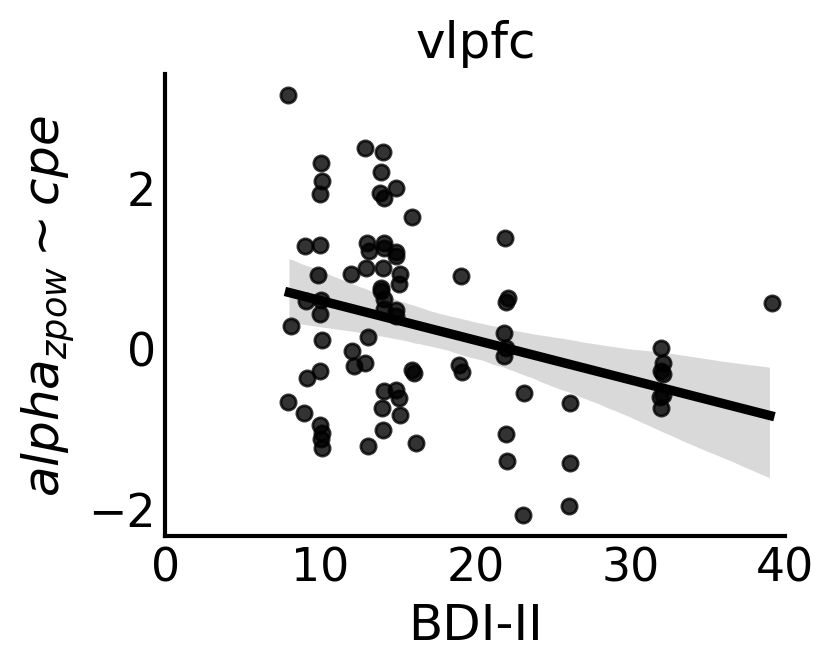

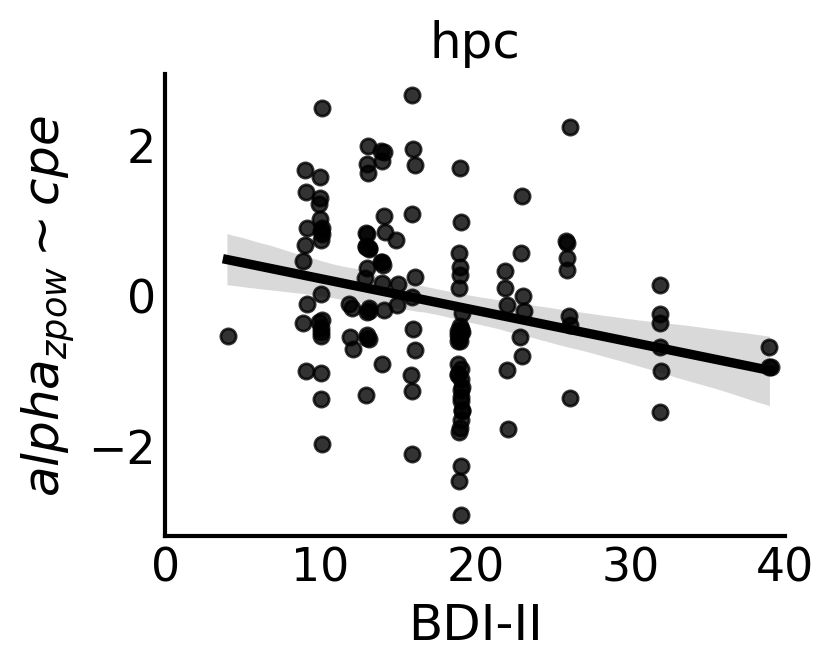

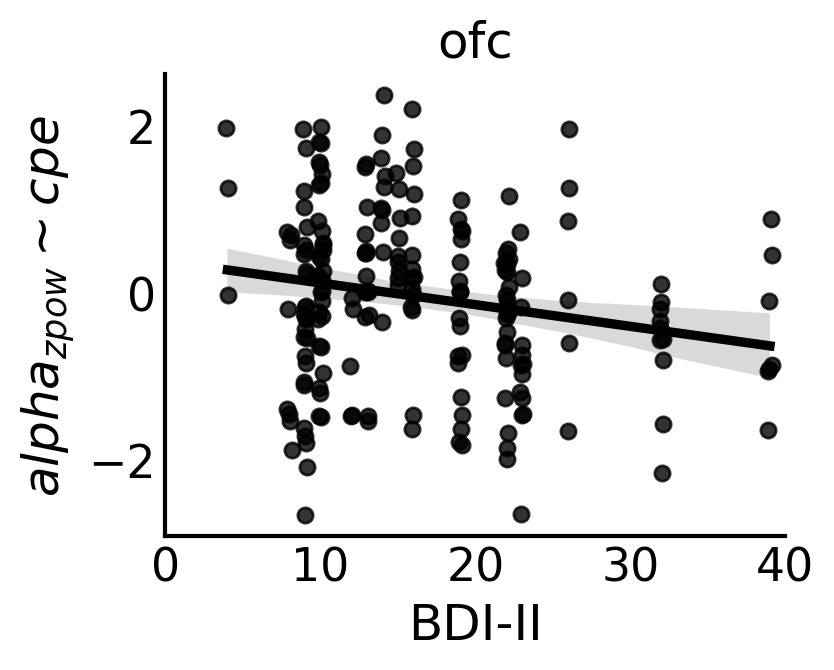

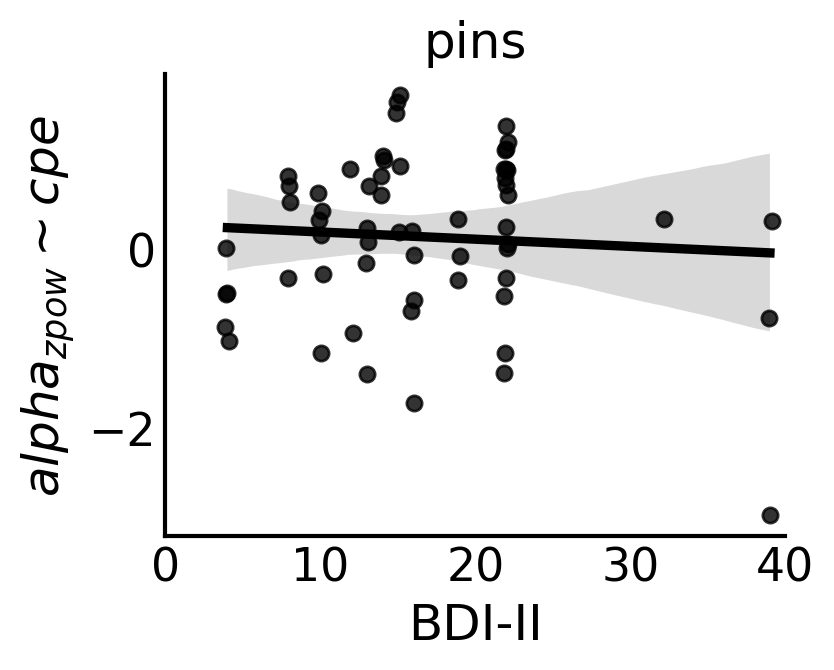

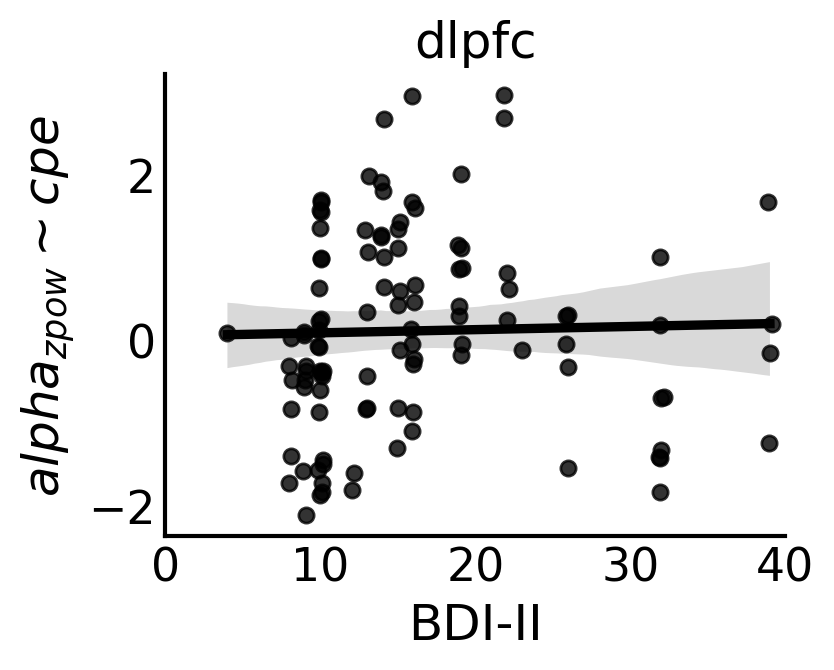

In [30]:
sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in single_elec_res.roi.unique().tolist():
    
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
    
    corr_fig_id = f'{band}_{roi}_bdi_cpe_coeff_scatter_{epoch_len}.pdf'
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_cpe',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.15,scatter_kws={'s':30}) #034975

    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim cpe$')


    plt.title(f'{roi}')
    sns.despine()
    
    
    plt.savefig(f'{fig_dir}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)


### Test BDI Correlations via robust regression

In [31]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in single_elec_res.roi.unique().tolist():
    roi_df = single_elec_res[single_elec_res.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_cpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())




acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 25 Sep 2024                                         
Time:                        12:36:22                                         
No. Iterations:                    14                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.8392      0.440     35.973     

# Mixed effects models

In [33]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
# from matplotlib import cm


# # saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# # 671351
saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
saez_hex_cmap  = ListedColormap(saez_colors)
saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
#plot_palette = saez_linear_cmap.resampled(lutsize=30)
expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


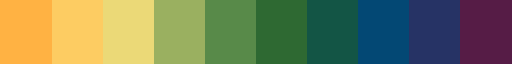

In [34]:
saez_full_cmap

In [62]:
expanded_cmap

['#ffb243',
 '#fdcd63',
 '#ecda77',
 '#9bb060',
 '#598a49',
 '#2e6a33',
 '#135546',
 '#034975',
 '#263365',
 '#561c46']

In [36]:
alpha_reg_df.columns

Index(['Unnamed: 0', 'subj_id', 'bdi', 'bdi_thresh', 'Round', 'RT',
       'TrialOnset', 'ChoiceOnset', 'DecisionOnset', 'FeedbackOnset',
       'ChoicePos', 'TrialType', 'SafeBet', 'LowBet', 'HighBet',
       'GambleChoice', 'Outcome', 'Profit', 'TotalProfit', 'epoch', 'logRT',
       'GambleEV', 'TrialEV', 'CR', 'choiceEV', 'rpe', 'res_type', 'cf',
       'max_cf', 'cpe', 'max_cpe', 'Round_t1', 'RT_t1', 'ChoicePos_t1',
       'TrialType_t1', 'SafeBet_t1', 'LowBet_t1', 'HighBet_t1',
       'GambleChoice_t1', 'Outcome_t1', 'Profit_t1', 'TotalProfit_t1',
       'epoch_t1', 'logRT_t1', 'GambleEV_t1', 'TrialEV_t1', 'CR_t1',
       'choiceEV_t1', 'rpe_t1', 'res_type_t1', 'cf_t1', 'max_cf_t1', 'cpe_t1',
       'max_cpe_t1', 'keep_epoch', 'keep_epoch_t1', 'CpeOnset',
       'reref_ch_names', 'band_pow', 'roi', 'hemi', 'unique_reref_ch'],
      dtype='object')

In [37]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
reg_vars     = ['GambleChoice','TotalProfit', 'cpe']
rand_vars    = ['GambleChoice','TotalProfit', 'cpe']


In [38]:
roi_fit_dict = {f'{roi}':fit_mixed_model(alpha_reg_df[alpha_reg_df.roi==roi],
                                        reg_vars,rand_vars,outcome_var,rand_eff_var) 
                for roi in alpha_reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],alpha_reg_df[alpha_reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)
roi_fit_results['band'] = 'alpha'
roi_fit_results.to_csv(f'{save_dir}{band}_mlm_roi_fit_results_{epoch_len}_{date}.csv')

In [39]:
roi_fit_results

,unique_reref_ch,subj_id,region_type,bdi,raw_Intercept,raw_GambleChoice[T.safe],raw_GambleChoice[T.skip],raw_TotalProfit,raw_cpe,Intercept,GambleChoice[T.safe],GambleChoice[T.skip],TotalProfit,cpe,band
0,DA023_lac1-lac2,DA023,acc,14,-0.023150,0.006485,-0.012003,0.001207,0.000960,0.015547,-0.021597,-0.030953,0.010926,-0.003931,alpha
1,DA023_lac2-lac3,DA023,acc,14,0.004149,-0.034910,-0.142694,0.043925,0.002519,0.042845,-0.062992,-0.161644,0.053643,-0.002371,alpha
2,DA023_lac3-lac4,DA023,acc,14,-0.010675,0.020538,-0.009742,0.003103,0.000948,0.028022,-0.007544,-0.028692,0.012821,-0.003943,alpha
3,MS002_lacas1-lacas2,MS002,acc,14,0.058897,-0.085428,-0.063059,0.024585,-0.002661,0.097594,-0.113510,-0.082009,0.034303,-0.007552,alpha
4,MS002_lacas2-lacas3,MS002,acc,14,-0.032898,0.007523,-0.080023,0.021020,0.003119,0.005799,-0.020560,-0.098973,0.030738,-0.001771,alpha
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,MS050_rainss10-rainss11,MS050,dlpfc,9,-0.073698,0.018102,-0.058655,-0.025849,-0.005296,-0.100443,0.011658,-0.287770,-0.004947,-0.000013,alpha
1184,MS050_rainss11-rainss12,MS050,dlpfc,9,-0.028579,-0.009110,-0.056746,-0.023275,-0.008853,-0.055324,-0.015554,-0.285861,-0.002374,-0.003571,alpha
1185,MS050_rainss6-rainss7,MS050,dlpfc,9,0.106670,0.066952,0.064919,-0.009780,-0.015909,0.079925,0.060508,-0.164195,0.011121,-0.010626,alpha
1186,MS050_rainss7-rainss8,MS050,dlpfc,9,0.035710,0.103583,0.189273,-0.033795,-0.065400,0.008965,0.097139,-0.039842,-0.012894,-0.060117,alpha


In [40]:
# roi_fit_results

fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
fe_results = []
for fe_res in fe_params_results:
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))
    
fe_results = pd.concat(fe_results).reset_index(drop=True)
fe_results['cpe_pval'] = [np.round(roi_fit_dict[roi].pvalues['cpe'],4) for roi in fe_results.roi.tolist()]
# fe_results['bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi'],4) for roi in fe_results.roi.tolist()]
# fe_results['cpe_bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi:decisionCPE'],4) for roi in fe_results.roi.tolist()]

fe_results


,Intercept,GambleChoice[T.safe],GambleChoice[T.skip],TotalProfit,cpe,roi,cpe_pval
0,0.038697,-0.028083,-0.018950,0.009718,-0.004891,acc,0.2674
1,-0.000622,-0.013349,0.022381,0.004462,-0.007628,dmpfc,0.0659
2,-0.029344,-0.007235,-0.079774,0.014569,0.005155,amy,0.4314
3,-0.020228,0.012302,-0.276155,-0.012149,0.009530,ains,0.2864
4,-0.062172,-0.003448,-0.371847,-0.005856,0.015263,vlpfc,0.0320
5,-0.079490,0.012750,-0.032679,0.004804,-0.004670,hpc,0.3431
6,-0.051271,0.000661,-0.025573,0.000536,-0.003415,ofc,0.4177
7,-0.014844,0.022007,-0.290152,0.007245,0.007349,pins,0.3501
8,-0.026745,-0.006444,-0.229114,0.020902,0.005283,dlpfc,0.4426


In [41]:
fe_results.set_index('roi')

,Intercept,GambleChoice[T.safe],GambleChoice[T.skip],TotalProfit,cpe,cpe_pval
roi,,,,,,
acc,0.038697,-0.028083,-0.018950,0.009718,-0.004891,0.2674
dmpfc,-0.000622,-0.013349,0.022381,0.004462,-0.007628,0.0659
amy,-0.029344,-0.007235,-0.079774,0.014569,0.005155,0.4314
ains,-0.020228,0.012302,-0.276155,-0.012149,0.009530,0.2864
vlpfc,-0.062172,-0.003448,-0.371847,-0.005856,0.015263,0.0320
hpc,-0.079490,0.012750,-0.032679,0.004804,-0.004670,0.3431
ofc,-0.051271,0.000661,-0.025573,0.000536,-0.003415,0.4177
pins,-0.014844,0.022007,-0.290152,0.007245,0.007349,0.3501
dlpfc,-0.026745,-0.006444,-0.229114,0.020902,0.005283,0.4426


In [42]:
bonferr_alpha = 0.05/len(fe_results)
# bonferr_alpha = 0.01

bonferr_alpha



0.005555555555555556

In [43]:
sig_cpe_rois = fe_results.roi[fe_results.cpe_pval <= bonferr_alpha].tolist()
sig_cpe_rois



[]

In [44]:

raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results.cpe[roi_fit_results.region_type == roi].unique(),
                 popmean=0) for roi in roi_fit_results.region_type.unique().tolist()}
raw_roi_stats



{'acc': TtestResult(statistic=-17.368179501242924, pvalue=3.116295850617741e-41, df=192),
 'dmpfc': TtestResult(statistic=-6.487897236613787, pvalue=5.50961238370051e-10, df=224),
 'amy': TtestResult(statistic=2.568650918755133, pvalue=0.011525007151331335, df=112),
 'ains': TtestResult(statistic=2.935486590838129, pvalue=0.004502184831666326, df=70),
 'vlpfc': TtestResult(statistic=6.224523400029137, pvalue=2.019788537640622e-08, df=81),
 'hpc': TtestResult(statistic=-3.4207268412443184, pvalue=0.0008282199109997782, df=134),
 'ofc': TtestResult(statistic=-3.150210925596688, pvalue=0.0018805166597405806, df=201),
 'pins': TtestResult(statistic=6.9412171863717225, pvalue=3.401602204996549e-09, df=59),
 'dlpfc': TtestResult(statistic=2.087312142496048, pvalue=0.039257538944676235, df=106)}

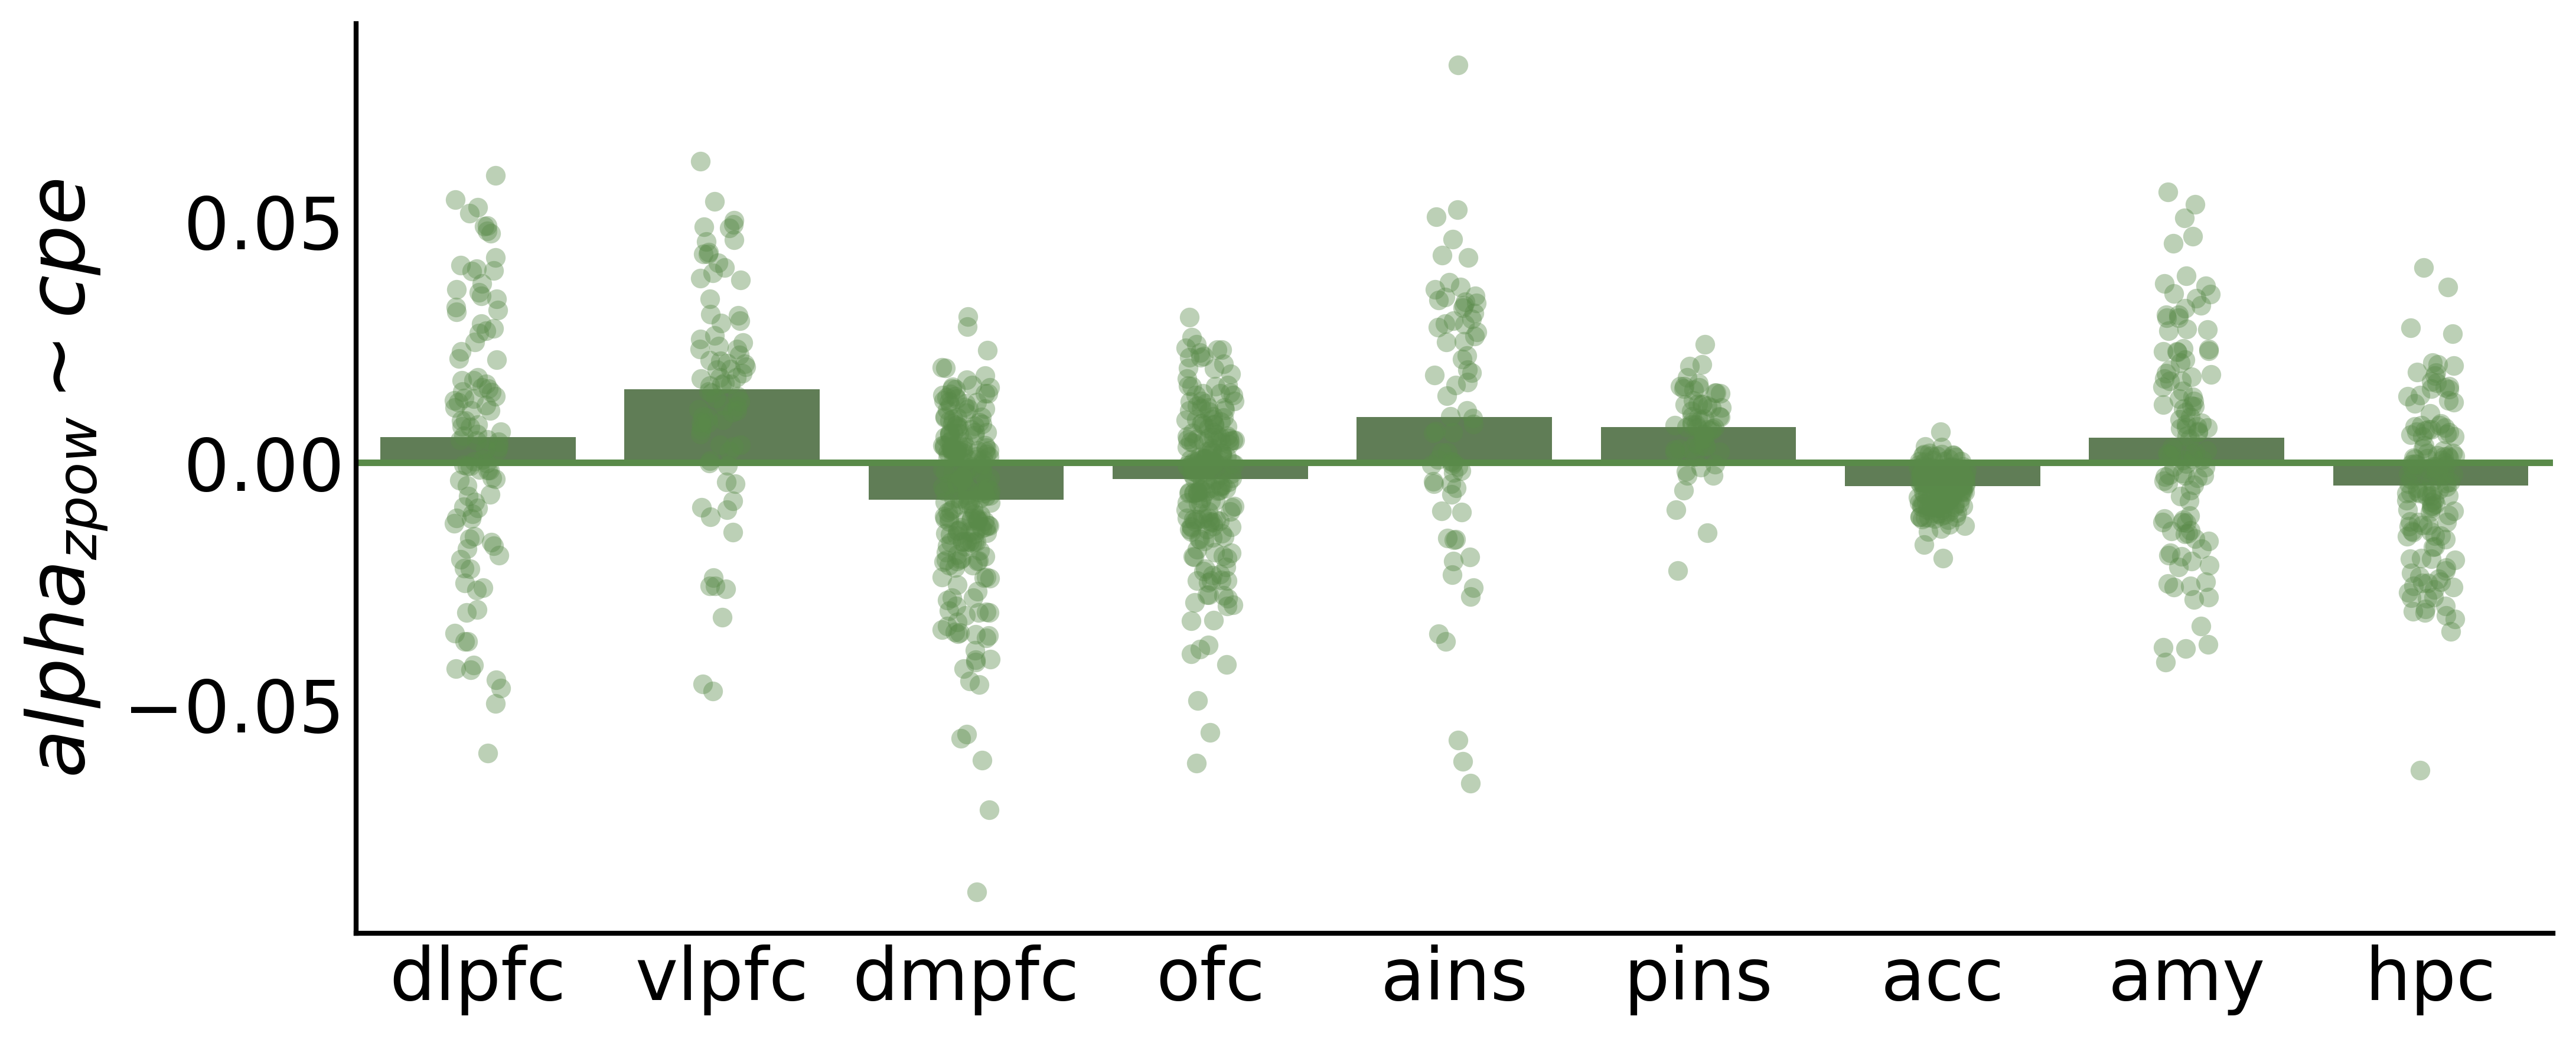

In [45]:
ylabel = fr'${band}_{{zpow}} \sim cpe$'
# fig_save_dir = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/results/single-electrode-regressions/'
fig_id = f'{band}_mlm_roi_barplot_{epoch_len}.pdf'


plot_roi_model_results(roi_fit_results,'region_type','cpe',bar_order=bar_order,figsize=(12,5),color='#598a49',
                       ylabel=ylabel,save_fig=True,save_dir=fig_dir,fig_id=fig_id,dpi=400)



# BDI Correlation

In [46]:
# CHECK BDI CORRELATION

rho_data = []
sig_rho = []

# BDI CORRELATIONS
for roi in roi_fit_results.region_type.unique().tolist():
    roi_temp_data = roi_fit_results[roi_fit_results.region_type==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.cpe)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


acc pearsonr -0.1967819809658656 0.006090012459857387
dmpfc pearsonr -0.25375144379265113 0.0001189659477878613
amy pearsonr 0.08847545639168491 0.3513990822999675
ains pearsonr 0.11786609288591808 0.3276064133475674
vlpfc pearsonr -0.13629452705687956 0.22210154265200466
hpc pearsonr -0.09748875518557482 0.26064596216459773
ofc pearsonr -0.042645326994900604 0.5467636112886008
pins pearsonr -0.02725993644821849 0.8362042607951107
dlpfc pearsonr -0.07937209888700147 0.41640661701808124


In [47]:
sig_rho

[('acc', -0.1967819809658656, 0.006090012459857387),
 ('dmpfc', -0.25375144379265113, 0.0001189659477878613)]

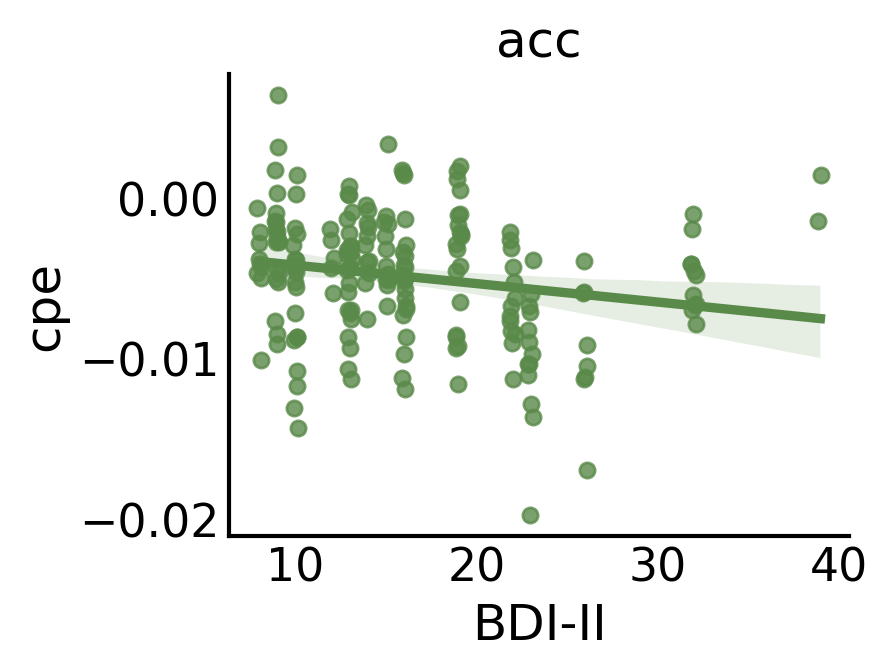

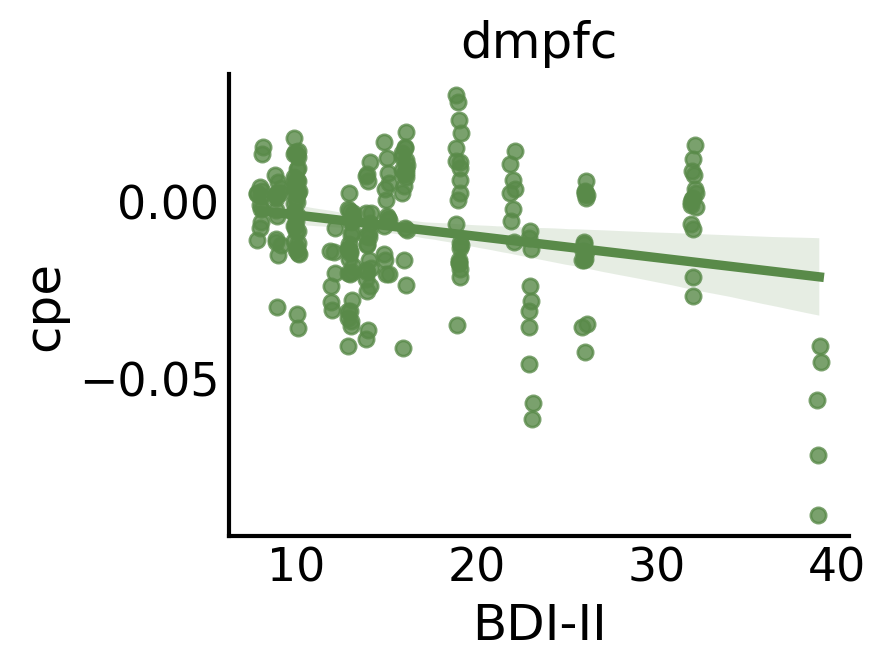

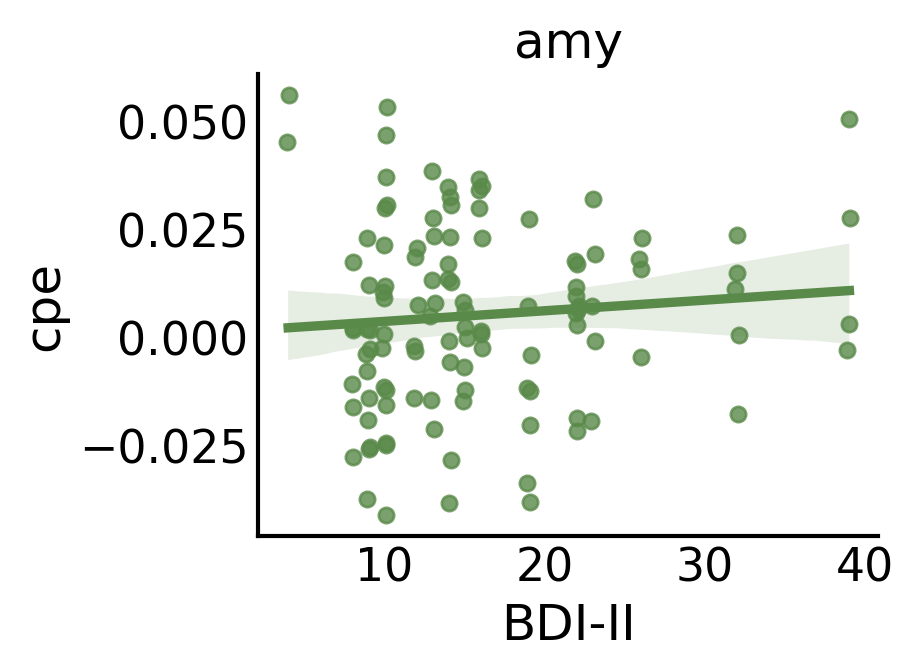

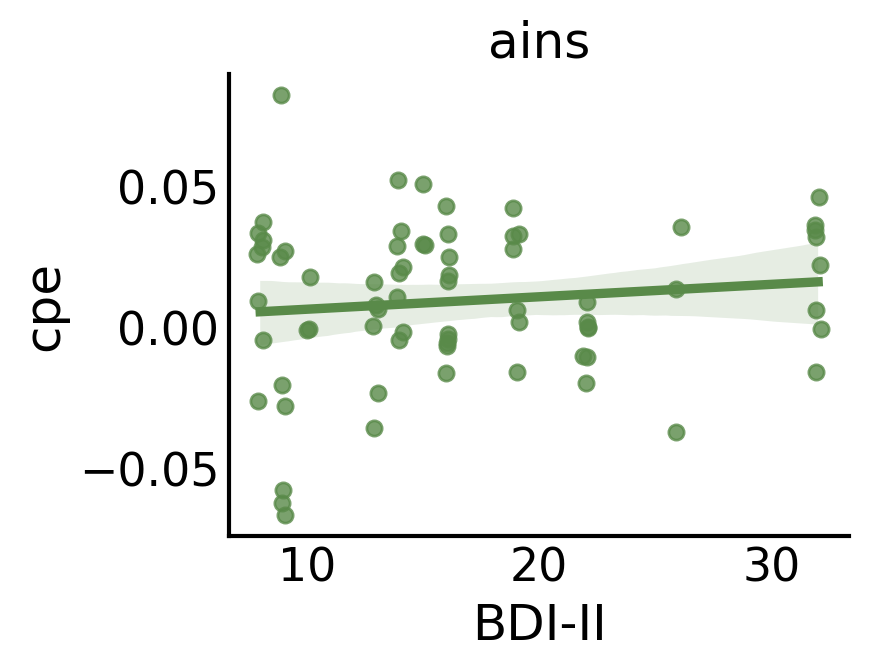

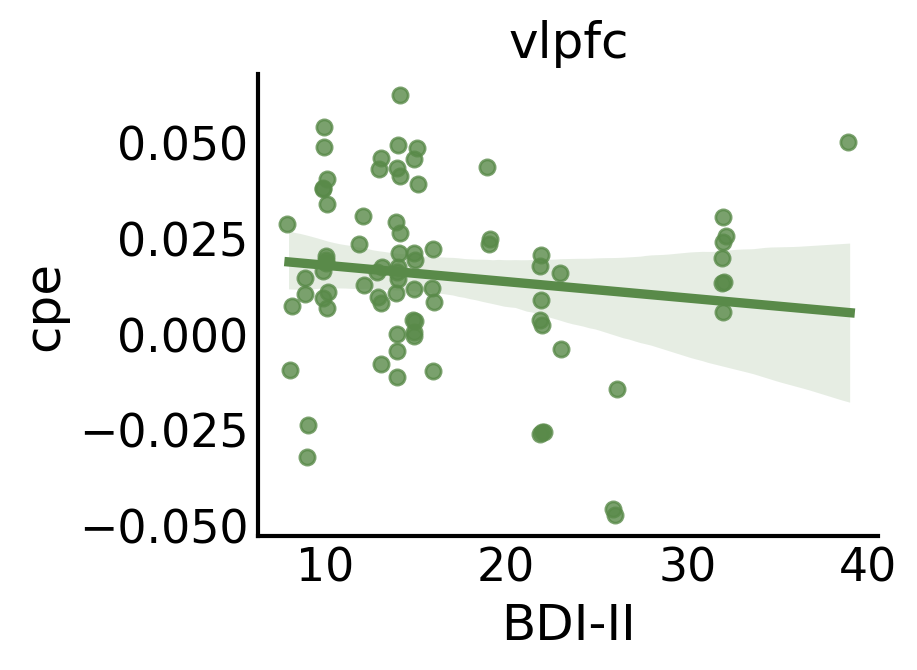

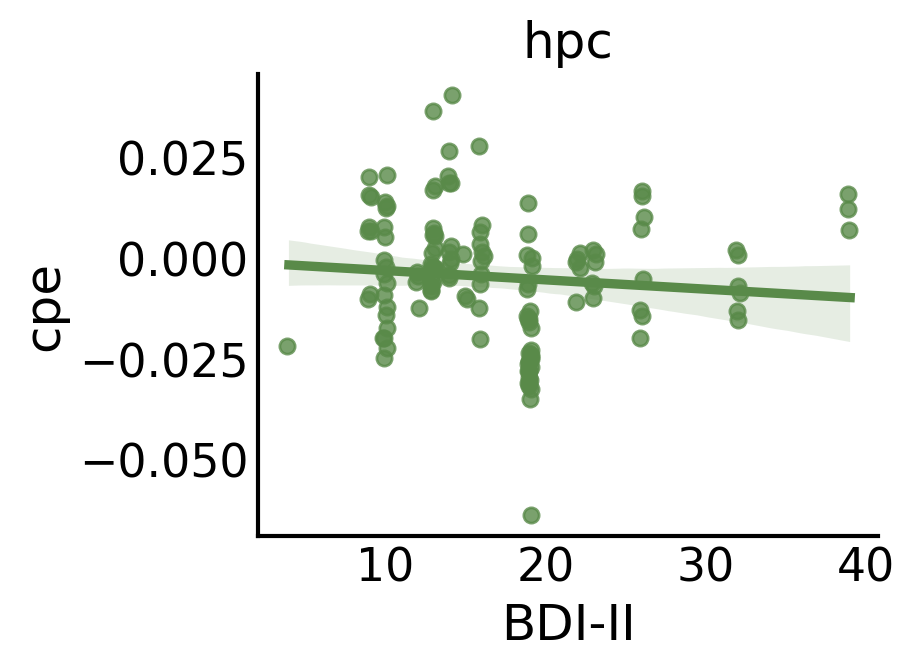

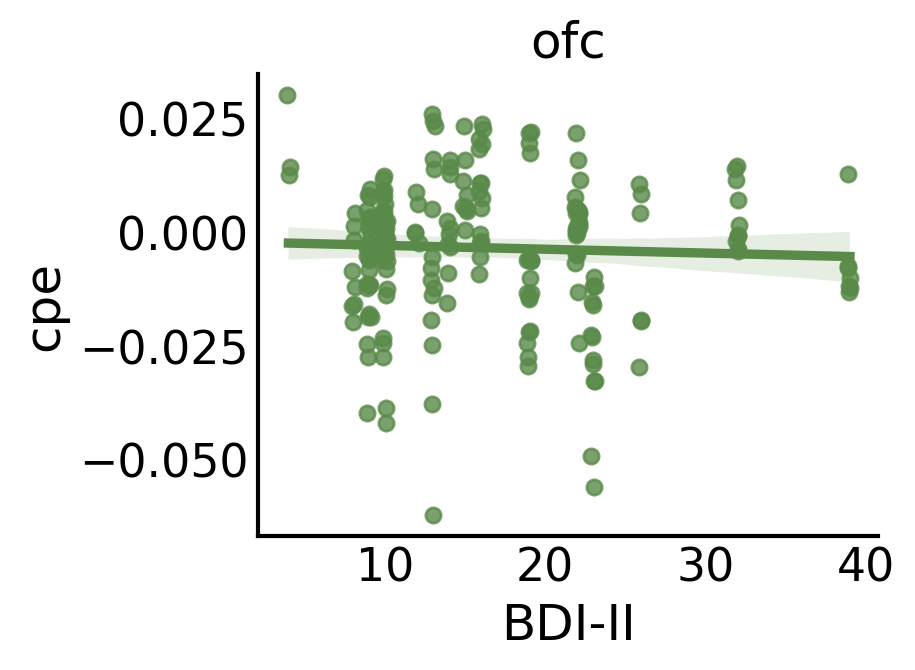

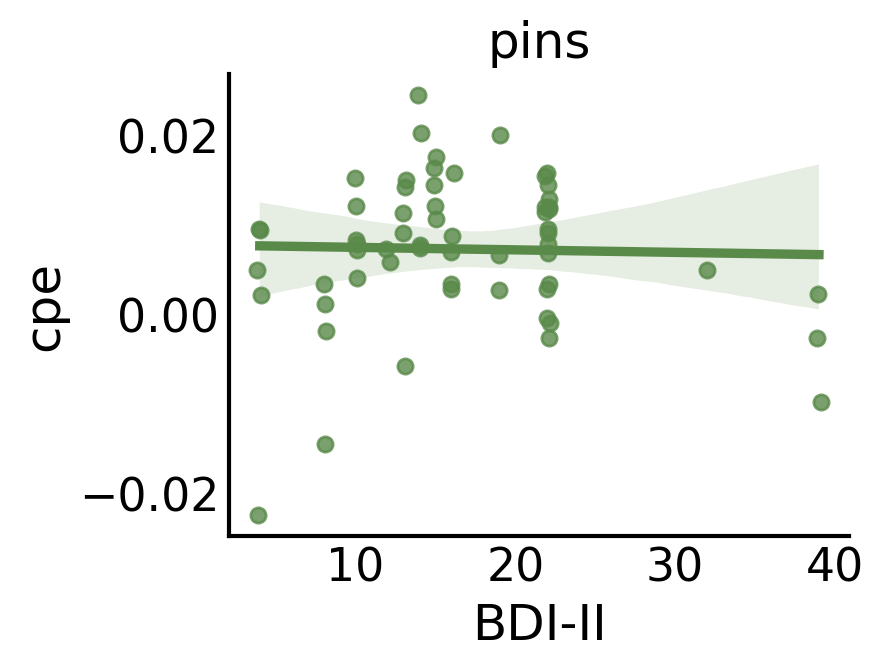

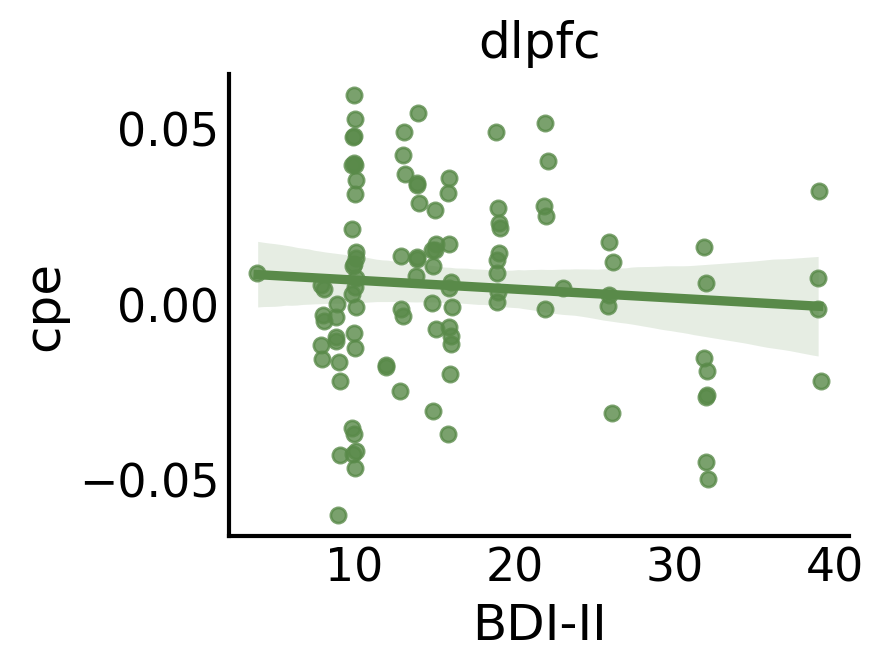

In [48]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in roi_fit_results.region_type.unique().tolist():
    
    roi_temp_data = roi_fit_results[roi_fit_results.region_type==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='cpe',scatter=True,ci=95,
                fit_reg=True,color = '#598a49',x_jitter = 0.15,scatter_kws={'s':30}) #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
#     plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
#     plt.ylabel(fr'${band}_{{{zpow}}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}')
    sns.despine()
#     plt.tight_layout()


    
#     sns.despine()
    
    plt.savefig(f'{fig_dir}/{roi}_{rho}_{rho_p}_roi_bdi_{band}-cpe-slope_{epoch_len}.pdf', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=300,
        facecolor='auto', edgecolor='auto',
        backend=None)
    

In [49]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in roi_fit_results.region_type.unique().tolist():
    roi_df = roi_fit_results[roi_fit_results.region_type == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.cpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())




acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 25 Sep 2024                                         
Time:                        02:23:58                                         
No. Iterations:                    15                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.7671      0.664     20.720     